# Verificando os dados extraídos

Na aula anterior fizemos o processamento inicial dos dados, e podemos resumir isso em um único módulo (preprocess)! Agora, para resumir tudo que fizemos antes, precisamos apenas fazer o seguinte

In [1]:
from context import fakenews
from fakenews import preprocess as pre

base = '/home/thalesaguiar/Dev/FakeNews/'
news, labels = pre.run(base + 'data/Fake.csv', base + 'data/True.csv')
print(news[0][:10])

Succesfully read data from:
Fakes: /home/thalesaguiar/Dev/FakeNews/data/Fake.csv
Reals: /home/thalesaguiar/Dev/FakeNews/data/True.csv
Removing rows without text...
Removing publisher information...
Adding class column...
Merging fakes and reals
Merging titles and bodies...
Removing subjects and date...
Tokenizing data...
['donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald']


Agora, com as sentenças prontas para fazermos nosso processamento!

Vamos verificar qual a distribuição da quantidade de palavras em cada sentença

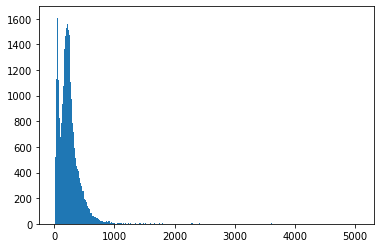

In [2]:
import matplotlib.pyplot as plt

news_lens = [len(new) for new in news]
histogram = plt.hist(news_lens, bins=500)
plt.show()

Como podemos ver, a distribuição está bastante irregular. Podemos poupar tanto tempo de processamento (ou seja, nosso tempo) truncando essa notícias!

Note que truncar foi apenas um método que eu escolhi, outra abordagem poderia ser dividir amostras grandes em várias amostras menores.

Primeiro, vamos identificar os parâmetros da nossa distribuição

In [3]:
import numpy as np

avg = np.mean(news_lens)
std = np.std(news_lens)
print(f'Average: {avg}')
print(f'Std: {std}')

Average: 248.2148101294418
Std: 206.8736133506386


Uma abordagem é combinar a média e o desvio padrão da distribuição. Agora podemos, por exemplo, verificar quantas amostras possuem mais palavras do que AVG + 2*STD

In [4]:
oversized = np.where(news_lens > avg + 3*std)[0]
len(oversized)

469

Então, temos 469 amostras com uma quantidade de palavras maior que AVG + 2*STD. Isso representa

In [5]:
print(f'{469/len(news_lens) * 100:.2f}%')

1.06%


dos dados. Portanto, podemos truncar as amostras em AVG + 3*STD tokens.

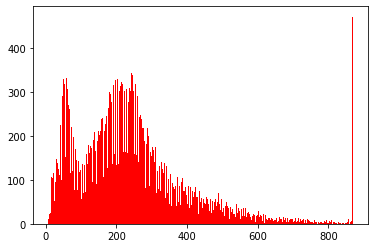

In [6]:
import math

maxlen = int(math.ceil(avg + 3*std))
trunc_news = [new[:maxlen] for new in news]
tnews_lens = [len(new) for new in trunc_news]

hist = plt.hist(tnews_lens, bins=500, color='red')
plt.show()

Agora temos uma melhor distribuição dos nossos dados! Vamos para extração de características. Uma função para truncar os dados também está disponível no módulo preprocess!

## Representando palavras

Como sabemos, não da pra usar string dentro de modelos matemáticos. Pra isso, devemos encontrar uma forma numérica para representar a característica que queremos enfatizar. Duas abordagens comuns para isso são o _One-Hot-Encoding_ e o _BagOfWords_.

O **One-Hot-Encoding** possui cada palavra em uma dimensão nova, por exemplo

In [7]:
words = ['the', 'blitzkrieg', 'bop']
nwords = len(words)
encodes = np.identity(nwords)
encodes

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Dessa forma, nosso espaço de características possui $N$ dimensões e cada palavra reside em uma dimensão.
Vamos visualizar como eles ficam distribuídos

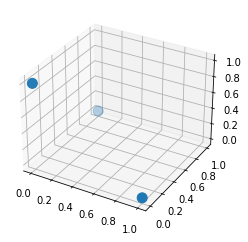

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xoord = encodes[:, 0]
yoord = encodes[:, 1]
zoord = encodes[:, 2]
scatter = ax.scatter(xoord, yoord, zoord, marker='o', s=100)
plt.show()

Como podemos visualizar, as palavras 'blitzkrieg' e 'bop' são totalmente alheios por mais que sejam letras da música de Ramones e também se refira a táticas usadas na segunda guerra mundial.

Outra forma de representação seria scalar os vetores pela frequência da palavra na frase. Note que apenas adicionamos dimensões para novas palavras!

In [9]:
words = ['hey', 'ho', 'lets', 'go', 'hey', 'ho', 'lets', 'go']
ndim = np.unique(words).size
encodes_lower_dim = np.identity(ndim) * 2
encodes_lower_dim

array([[2., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 2.]])

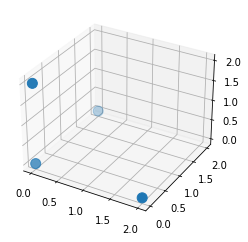

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xoord = encodes_lower_dim[:, 0]
yoord = encodes_lower_dim[:, 1]
zoord = encodes_lower_dim[:, 2]
scatter = ax.scatter(xoord, yoord, zoord, marker='o', s=100)
plt.show()

Agora temos a mesma coisa, só que indo mais longe '-'.
Também podemos usar o módulo preprocessing do SkLearn para gerar o one-hot-encoding, simples assim

In [11]:
from sklearn.preprocessing import OneHotEncoder

words_as_col = np.reshape(words, (-1, 1))
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(words_as_col)
print(encoder.categories_)

encoder.transform(words_as_col).toarray()

[array(['go', 'hey', 'ho', 'lets'], dtype='<U4')]


array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

Enquanto essas representações sejam de certa forma boas por serem simples e apresentarem resultados bons, elas não preservam características sintáticas ou semânticas entre as palavras. Por exemplo, sinônimos e antônimos são tratados da mesma forma!

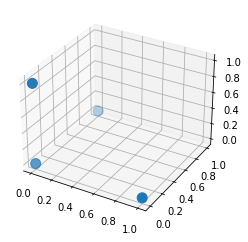

In [12]:
related = ['bom', 'ruim', 'excelente', 'pessimo']
ndim = np.unique(related).size
encodes_related = np.identity(ndim)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xoord = encodes_related[:, 0]
yoord = encodes_related[:, 1]
zoord = encodes_related[:, 2]
scatter = ax.scatter(xoord, yoord, zoord, marker='o', s=100)
plt.show()

Outra representação seria usando Bag-of-Words, onde cada frase possui dimensão $1 \times N$ onde $N$ é a quantidade de palavras únicas na frase. Em seguida, a dimensão de cada vetor (Bag of Word) é $L$, onde $L$ é quantidade de palvras únicas em todas as frases. Por exemplo

In [13]:
sent1 = ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
sent2 = ['the', 'slow', 'red', 'fox', 'jumps', 'around', 'the', 'sleeping', 'dog']

bow = {}
i = 0
for word in sent1 + sent2:
    if word not in bow:
        bow[word] = i
        i += 1

print(bow)

{'the': 0, 'quick': 1, 'brown': 2, 'fox': 3, 'jumps': 4, 'over': 5, 'lazy': 6, 'dog': 7, 'slow': 8, 'red': 9, 'around': 10, 'sleeping': 11}


Agora que sabemos quais são as palavras únicas do nosso conjunto de palavras e definimos um índice para cada uma, podemos representar nossas frases como bags da seguinte forma

In [14]:
def make_bag(sentence, indexes, dim):
    bag = np.zeros(dim)
    for word in sentence:
        idx = bow[word]
        bag[idx] += 1
    return bag

bag1 = make_bag(sent1, bow, len(bow))
bag2 = make_bag(sent2, bow, len(bow))
print(f'Bag1: {bag1}')
print(f'Bag2: {bag2}')

Bag1: [2. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Bag2: [2. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1.]


Essas _features_ foram usadas por um certo tempo, mas devido as suas limitações outras formas de representações surgiram. Também é interessante notar que essas técnicas não são exclusivas de representação de palavras. Podemos usar isso para praticamente qualquer tipo de característica. Por exemplo, para representar as cores. De forma semelhante, também podemos usar o SkLearn para processar esses dados.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer


data = ['the quick brown fox jumps over the lazy dog',
        'the slow red fox jumps around the sleeping dog']

extractor = CountVectorizer()
feats = extractor.fit_transform(data)
extractor.get_feature_names()

['around',
 'brown',
 'dog',
 'fox',
 'jumps',
 'lazy',
 'over',
 'quick',
 'red',
 'sleeping',
 'slow',
 'the']

E para visualizar os arrays

In [16]:
feats.toarray()

array([[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2],
       [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2]])

ou visualizar o índice de cada palavra

In [17]:
extractor.vocabulary_.get('the')

11

Além disso, também podemos usar n-grams para representar um documento. Eles podem ser usados para levar em consideração erros de digitação e levam em consideração um pouco de contexto de cada sentença.

Com sklearn é fácil do mesmo jeito!

In [18]:
bigram_model = CountVectorizer(ngram_range=(1, 2), 
                               token_pattern=r'\b\w+\b', min_df=1)

bifeats = bigram_model.fit_transform(data)
bigram_model.get_feature_names()

['around',
 'around the',
 'brown',
 'brown fox',
 'dog',
 'fox',
 'fox jumps',
 'jumps',
 'jumps around',
 'jumps over',
 'lazy',
 'lazy dog',
 'over',
 'over the',
 'quick',
 'quick brown',
 'red',
 'red fox',
 'sleeping',
 'sleeping dog',
 'slow',
 'slow red',
 'the',
 'the lazy',
 'the quick',
 'the sleeping',
 'the slow']

os vetores de cada um

In [19]:
bifeats.toarray()

array([[0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 0, 0],
       [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        2, 0, 0, 1, 1]])

e os índices

In [20]:
bigram_model.vocabulary_.get('fox')

5

Em ambos os casos, podemos analisar sentenças para processar os dados

In [21]:
analyse = bigram_model.build_analyzer()
analyse('Fox jumps around')

['fox', 'jumps', 'around', 'fox jumps', 'jumps around']

Muito divertido, muito legal! Mas vamos verificar quantas dimensões precisamos para modelar nossas fakenews. Vamos usar apenas a primeira amostra com um unigrama

In [22]:
print(len(news[0]))
unigram = CountVectorizer()

unigram.fit_transform([' '.join(new) for new in news])

302


<44267x122238 sparse matrix of type '<class 'numpy.int64'>'
	with 7520884 stored elements in Compressed Sparse Row format>

### Representações automáticas com word2vec

Com o módulo gensim podemos usar modelos word2vec para ajustar nossos dados.

In [23]:
import gensim

model = gensim.models.Word2Vec(sentences=news, size=100, window=5, min_count=1)

Isso é suficiente para modelar as NOTÍCIAS

Podemos explorar um pouco como algumas palavras foram modeladas

In [24]:
model.wv['trump']

array([-0.27596608, -1.2342238 ,  0.11854783,  1.2323086 ,  1.3533841 ,
       -0.65864414,  0.7391096 , -1.2963692 ,  1.8474531 , -2.181095  ,
       -1.363007  , -0.8116152 ,  0.37633437,  2.3470945 ,  2.578792  ,
        0.7375896 , -1.2422233 ,  1.8486975 ,  0.3225941 ,  0.4806081 ,
        0.8481876 , -3.4870331 , -0.6544524 ,  0.5994764 ,  2.8886964 ,
        2.8551304 , -0.6859622 ,  1.2569509 ,  1.7849929 , -0.3148943 ,
       -0.14862406, -0.01052671,  0.7320086 ,  1.366817  , -1.4670578 ,
        0.80890036,  0.06243384,  0.29085302, -1.1607343 ,  1.1918848 ,
       -1.3908273 , -1.0581023 , -1.9189461 ,  0.9013595 ,  1.7343506 ,
        1.3176283 ,  0.8693285 ,  2.1461315 , -0.8019637 , -0.8393378 ,
       -0.7341497 , -3.595015  , -2.007655  , -0.5711366 , -0.7105635 ,
        0.7535783 ,  3.4008741 , -1.0758498 ,  0.32295388,  1.4521002 ,
       -0.57558745,  0.99873364, -0.7260116 , -0.04941798, -1.0959158 ,
       -0.63455844,  2.5002894 ,  0.8289418 ,  1.066114  , -0.38

wv realiza o acesso ao vetores, mais especificamente a uma classe com indexamento em hash do tipo Word -> Vetor

Também podemos buscar por palvras similares

In [25]:
model.wv.most_similar('trump')

[('elect', 0.6381902694702148),
 ('rps7svtfvf', 0.5658029913902283),
 ('kdmtphe7zouif', 0.5412342548370361),
 ('president', 0.5269486904144287),
 ('cruz', 0.5124491453170776),
 ('obama', 0.49867182970046997),
 ('macron', 0.4622005522251129),
 ('6qi7ktw43o', 0.46154341101646423),
 ('presidential', 0.4536900520324707),
 ('course', 0.4447691738605499)]

In [26]:
model.wv.most_similar('obama')

[('obamahe', 0.6086795330047607),
 ('incoming', 0.6053297519683838),
 ('obamafeatured', 0.5992143154144287),
 ('obamayou', 0.5873504877090454),
 ('inz58zkoam', 0.5793286561965942),
 ('khqim8ro4h', 0.5792835354804993),
 ('nmlwydsepo', 0.574662446975708),
 ('huessein', 0.5735125541687012),
 ('snjvd6jdmd', 0.550853431224823),
 ('obamaobama', 0.5439697504043579)]

In [27]:
model.wv.most_similar('smartphone')

[('android', 0.8303415775299072),
 ('smartphones', 0.7738503813743591),
 ('app', 0.75669926404953),
 ('portable', 0.7518602609634399),
 ('apps', 0.7456697225570679),
 ('encrypted', 0.7187948226928711),
 ('automated', 0.7145309448242188),
 ('algorithm', 0.714138388633728),
 ('storage', 0.7139924764633179),
 ('stratosphereon', 0.7067301869392395)]

Também podemos fornecer amostras negativas, limitando um pouco mais os resultados

In [28]:
model.wv.most_similar(positive=['trump', 'obama'], negative=['corona'])

[('mkdbxpkquvshere', 0.576190710067749),
 ('elect', 0.5297199487686157),
 ('dithering', 0.5136561393737793),
 ('incoming', 0.5131688117980957),
 ('unexciting', 0.5009456872940063),
 ('obamahe', 0.48040738701820374),
 ('bush', 0.4392712712287903),
 ('however', 0.4379258155822754),
 ('ousters', 0.4352378845214844),
 ('foreshortened', 0.43184196949005127)]

Medir a similaridade entre duas palavras

In [29]:
model.wv.similarity('hilary', 'pence')

-0.11140213

In [30]:
model.wv.similarity('trump', 'pence')

0.44012848

Ele até conserva, de certa maneira, o contraste entre o vice presidente Pence e a cnadidata Hilary! E quanto ao Biden?

In [31]:
model.wv.similarity('biden', 'pence')

0.5254186

Ora ora, veja só :). A similaridade (cosseno) é ainda maior que a relação entre Trump e Pence!

Agora, vamos salvar os resultados para não precisar executar tudo novamente!

In [32]:
model.save('fakenews-w2v.model')

In [33]:
model = gensim.models.Word2Vec.load('fakenews-w2v.model')
model.wv['obama']

array([ 0.74553007, -2.0283327 ,  0.7757071 , -4.056399  ,  2.3566093 ,
       -2.9636161 , -1.7033607 , -1.0709264 ,  2.151731  , -2.1101615 ,
       -0.48760542, -0.9038621 ,  0.29064295,  4.8211646 ,  5.1476693 ,
        1.1020178 , -4.4421906 ,  0.4050639 ,  0.75510967,  1.5080373 ,
        2.3671374 , -4.3152175 ,  4.9448752 ,  0.41718698,  7.2898083 ,
        2.222006  , -0.5355428 ,  1.9496531 ,  1.3802247 ,  1.9404893 ,
        0.60053855, -0.9162047 ,  0.11351857,  0.6513663 , -1.7646669 ,
        1.2976162 ,  1.6951259 ,  1.1259485 , -0.36013043,  1.0926195 ,
       -0.40988123, -1.2722242 , -1.400412  ,  0.9395158 ,  1.9809525 ,
        3.076234  , -0.90690583,  1.7050372 ,  3.1839635 ,  1.1328926 ,
        0.47845647, -2.9528985 ,  0.13435239,  0.06352313,  0.25161266,
       -0.45309857,  1.9685737 , -0.52939856,  1.3803606 , -1.5972401 ,
        1.3691881 ,  2.8411121 ,  0.58089507,  2.7407854 ,  2.63314   ,
        0.6694183 , -0.85090786,  1.1862698 ,  2.2955787 ,  0.61

Podemos usar dimensões diferentes para comparar os resultados e verificar qual o impacto disso na classficação das fakenews! Para isso, precisamos apenas criar outros modelos alterando o parâmetro 'size'

### Ground-up

Também podemos fazer nosso próprio modelo, e sugerir alterações. Lembrando que, embora os frameworks forneçam uma forma simples e rápida para tratar desses problemas, o problema **já está resolvido!** Portanto, não é tão interessante do ponto de vista acadêmico, enquanto que para desenvolvimento de aplicações é bastante útil!

Logo, é interessante entender as vantagens e limitações dos modelos para sugerir soluções caso queiramos dar um passo a frente na pesquisa.

Não é tão complicado quanto parece, os modelos usados pelo Mikulov são curiosamente simples. Na verdade, até mais simples que uma rede neural.